# Projekt SE
swfqedg


In [2]:
###############################################################################
# blabla
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
import pandas as pd
import numpy as np

from scipy.io import loadmat
from scipy.stats import kurtosis
from scipy.stats import skew

import time
from sys import getsizeof

from itertools import permutations, count #,izip

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg


from sklearn.model_selection import train_test_split

from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.losses import BinaryCrossentropy, mean_squared_error, KLDivergence# SparseCategoricalCrossentropy
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping


%load_ext autoreload
%autoreload 2

Hilfsfunktionen definieren

In [3]:
def plot_stats(dr, axis=0, color='tab:blue', plot=False):
        
    a = (np.std(dr, axis=axis))
    b = (np.var(dr, axis=axis))
    c = (skew(dr, axis=axis))
    d = (kurtosis(dr, axis=axis))
    
    if plot:
        fig = plt.figure(figsize=(15,7))
        ax = fig.add_subplot(111)

        ax.set_title('Histogramm')
        sns.distplot(dr,  ax=ax, color=color);
        #ax.legend((*hist.legend_elements()))
        plt.show()
    
    
        fig = plt.figure(figsize=(14,14))
        ax1 = fig.add_subplot(221)
        ax1.plot(a, 'tab:red', label='std')
        ax1.legend()
        ax2 = fig.add_subplot(222)
        ax2.plot(b, 'tab:green', label='var')
        ax2.legend()
        ax3 = fig.add_subplot(223)
        ax3.plot(d, 'tab:purple', label='kurtosis')
        ax3.legend()
        ax4 = fig.add_subplot(224)
        ax4.plot(c, 'tab:olive', label='skew')
        ax4.legend()
        plt.show()
    
    return a, b, c, d

In [4]:
def clust_eval(y_pred, y_train, name=""):
    fig1 = plt.figure(figsize=(16,6))
    gs = gridspec.GridSpec(1,2)

    ax1 = plt.subplot(gs[0])
    cnf_matrix = confusion_matrix(y_train,y_pred)
    row_sum = cnf_matrix.sum(axis=1,keepdims=True)
    #print(cnf_matrix)
    #print(row_sum)
    cnf_matrix_norm =cnf_matrix / row_sum
    sns.heatmap(cnf_matrix_norm,cmap='YlGnBu',annot=True, xticklabels=["1 good","0 defect"], yticklabels=["1 good","0 defect"])

    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    plt.title(f"Normalized Confusion Matrix - {name}")


    #ROC Curve Trainingdata 



    ax3 = plt.subplot(gs[1])

    fpr, tpr, thresholds = roc_curve(y_train, y_pred)

    roc_auc = auc(fpr, tpr)

    
    plt.plot(fpr, tpr, lw=1, alpha=0.9,
             label='ROC (AUC = %0.2f)' % (roc_auc))


    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.7)


    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    
    return roc_auc

In [5]:
def ae_classy(mse, threshold):
    y_pred_ae = []

    for i, loss in enumerate(mse):

        if loss >= threshold:
            y_pred_ae.append(0) # defect
        else:
            y_pred_ae.append(1) # good
            
    return y_pred_ae

In [6]:
def create_model(loss_fn = "mse", input_dim=2, file="autoencoder.h5"):    
    
    input_layer = Input(shape=(input_dim, ))

    encoder = Dense(int(input_dim / 2), activation="relu")(input_layer)

    dropout = Dropout(0.3)(encoder)

    encoder = Dense(int(input_dim / 4), activation="relu")(dropout)

    dropout = Dropout(0.3)(encoder)

    decoder = Dense(int(input_dim / 2), activation='relu')(dropout)

    decoder = Dense(input_dim, activation=None)(decoder)

    checkpointer = ModelCheckpoint(filepath=file,
                           verbose=0,
                           save_best_only=True)

    early_stopping = EarlyStopping(patience=patience,
                           verbose=0,
                           restore_best_weights=True)

    
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    
    autoencoder.compile(optimizer='adam', 
                    loss=loss_fn)
    #autoencoder.compile(optimizer='adadelta',
#                    loss='binary_crossentropy', 
#                    metrics=['accuracy'])

    
    return autoencoder, checkpointer, early_stopping

# MATLAB Matizen laden
Die Datensets befinden sich im MATLAB Format und werden zunachst geladen.

In [7]:

path = "D:/Documents/Uni/Special Engineering/Projektdaten/"

files = ["fftArray_defectLines.mat",
         "fftArray_goodLines.mat",
         "realSpace_defectLines.mat",
         "realSpace_goodLines.mat",
         "timeTable_defectLines.mat",
         "timeTable_goodLines.mat"]

keys =['fftFeat','fftFeat','realSpace','realSpace','timeTable','timeTable']


mat = []
data =[]

for f in files:
    mat.append(loadmat(path+f))

    
for i, m in enumerate(mat[:-2]):
    
    ds = m[keys[i]]
    
    print(getsizeof(ds),np.shape(ds),np.max(ds))
    
    data.append(pd.DataFrame(ds))
    
    #data.append(m[keys[i]])
#data = mat['fftFeat']

112 (111, 17089) 26.413447263145173
112 (109, 17236) 16.648241834407273
112 (223, 17089) 590.1683374744971
112 (218, 17236) 592.5773385229529


in erster Linie sind die ersten beiden Datensets interessant.


# Quellen

Measures of Skewness and Kurtosis
https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm


In [12]:

series = []
title = ['defect','good']

series.append(data[2].T[0:17089].T)
series.append(data[3].T[0:17089].T)

for s in series:
    print(np.shape(s))


(17089, 223)
(17089, 218)


# PCA on Realspace data
Aufgrund der extrem hohen Dimensionalistät bietet es sich an die Anzahl der Features mittel Pr zu reduzieren.

In [9]:
series_pca = []
pcas = []
pca = None



for t in series:
#
   # for i,_ in enumerate(t):
    t = t.T
    
    #l = np.size(t,1)/10

    pca = PCA(n_components=218)
    
    pc = pca.fit(t)
    pcas.append(pc)
    trans = pc.transform(t)
    
    series_pca.append(trans)

# Real Space

Analyse des Real Space

########################################## defect (17089, 223) (17089, 218) ##########################################


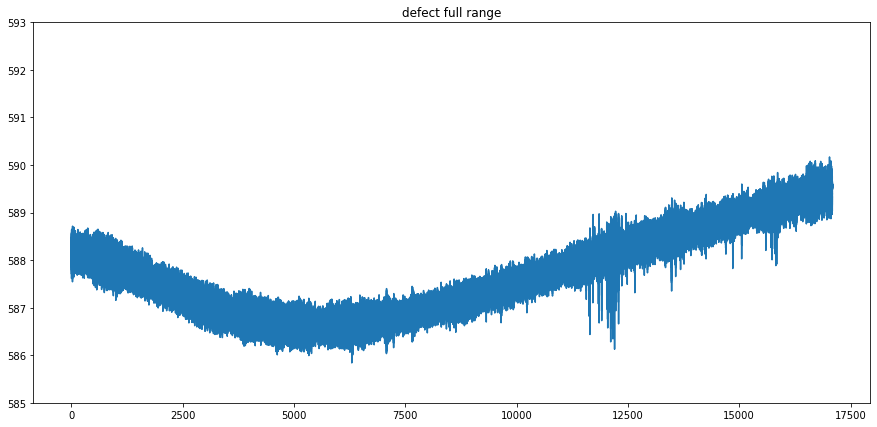

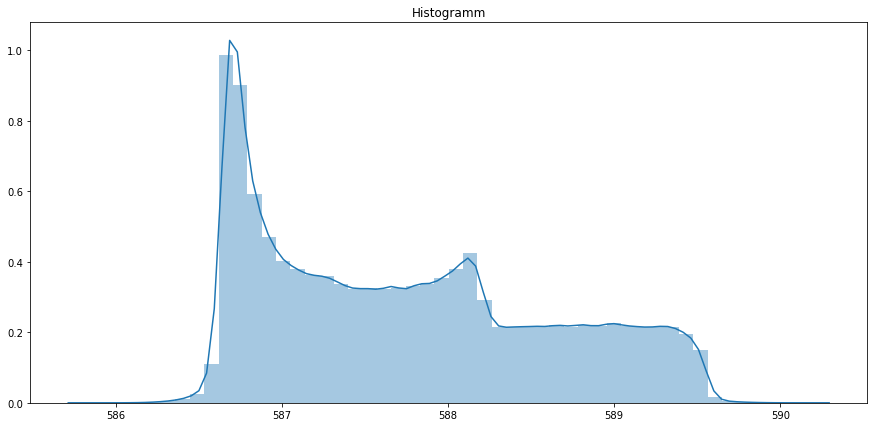

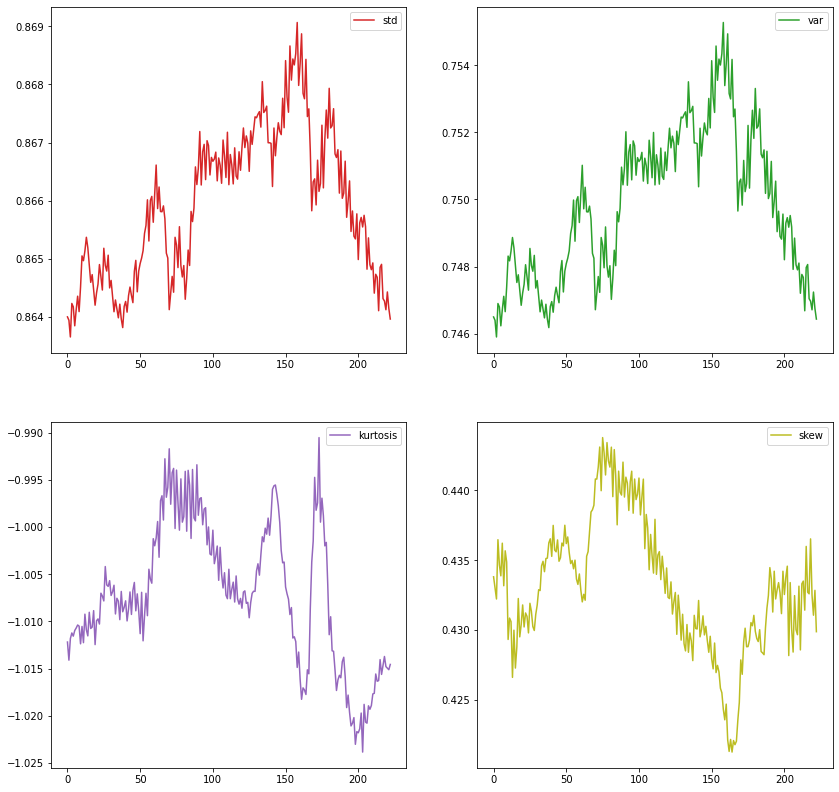

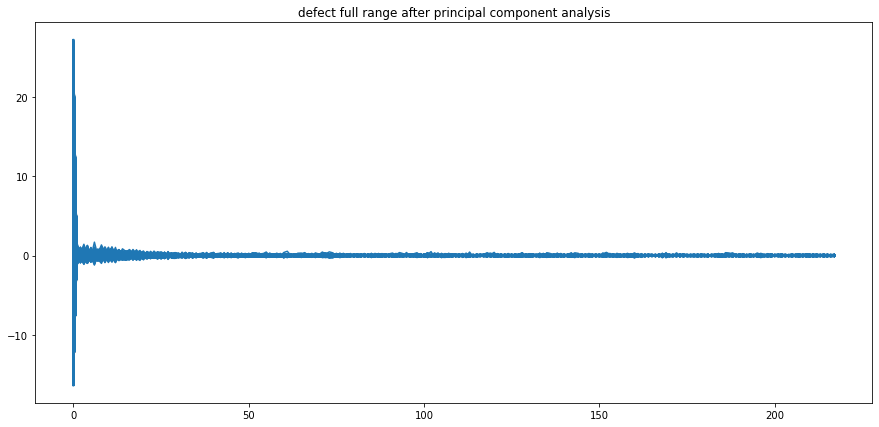

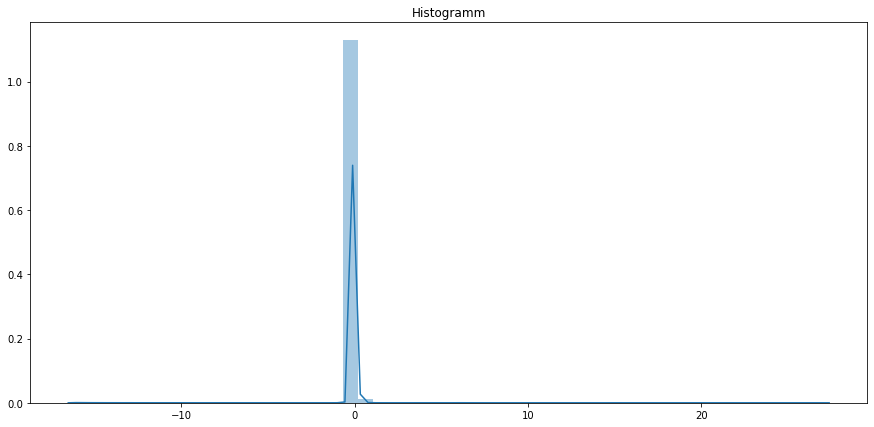

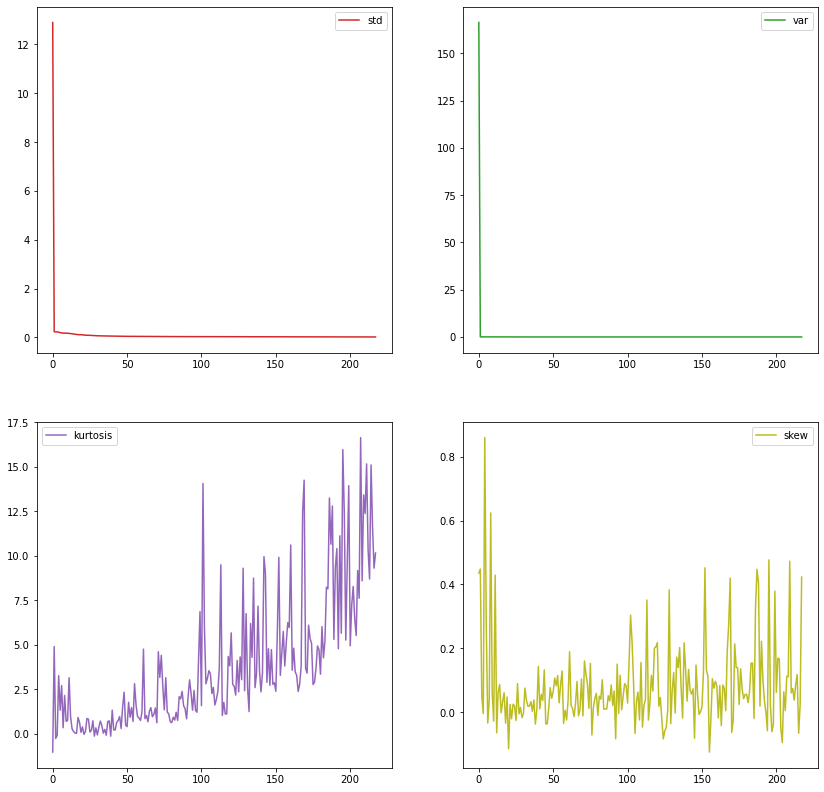

NameError: name 'X_train' is not defined

In [13]:

#######
X_train_pca = []
pcas = []
pca = None

#######


ra1 = range(0,218)
ra2 = range(55,109)
ra3 = range(110,164)
ra4 = range(164,218)

ra5 = [0,50,100,150,200]

for ind, s, sp, t, lab in zip(count(), series, series_pca, title, [0, 1]):
    
    color = cm.tab10(lab)
    
    #sp = sp.T
    print('##########################################'
          ,t,np.shape(s), np.shape(sp),'##########################################')
    
    #minmax
    #s = s / np.max(s)
    
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111)
    ax.set_title(f'{t} full range')
    ax.set_ylim([585,593])
    ax.plot(s, c=color)
    plt.show()
    
    plot_stats(s, 0, color, True)
    
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(111)
    ax1.set_title(f'{t} full range after principal component analysis')
    ax1.plot(sp.T, c=color)
    plt.show()
      
    plot_stats(sp, 0, color, True)
    
    
    for r in ra1:
      
        se = np.array(s[r])
        se_transformed = np.array(sp[r]).T
        
        #print(np.shape(se), np.shape(se_transformed))
        
        
        #fig = plt.figure(figsize=(14,12))
        #ax = fig.add_subplot(211)
        #ax1 = fig.add_subplot(212)
        
        #ax.set_title(f'{t} {r}')

        #ax.plot(se, c=color)
        #ax1.plot(se_transformed, c=color)
        
        #plt.show()
        
        
        a,b,c,d = plot_stats(se, 0)
        #print(f'original:\nstd {a}\nvar {b}\nskew {c}\nkurtosis {d}\n')
        
        se_transformed = np.r_[se_transformed, a, b, c, d]
        
        #print(se_transformed,'\n')
        
        a,b,c,d = plot_stats(se_transformed, 0)
        #print(f'after PCA:\nstd {a}\nvar {b}\nskew {c}\nkurtosis {d}\n')
        
        #se_transformed = np.r_[se_transformed, c, d]
        
        se_transformed = np.r_[se_transformed,lab]
        
        X_train = np.c_[X_train,se_transformed]
        #print(X_train)
        #X_train.append(se_transformed)
        #X_train.append(np.c_[se_transformed,a,c])

append stats

In [ ]:
X = X_train
Y = X_train[-1]

In [ ]:
X_train

In [ ]:
Y_train = X_train[-1]
X_train = X_train[:-1]


In [ ]:
print('number of labels =',len(Y_train),'\n')
X_train = pd.DataFrame(X_train.T)

print(X_train.describe())

# FFT Spektrum

Analy des FFT Spektrums

# concanate trainset

In [306]:
aucs = []

# GMM

In [13]:
# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.25, shuffle = True)

unique, counts = np.unique(y_train, return_counts=True)
print(unique,counts)


unique, counts = np.unique(y_valid, return_counts=True)
print(unique,counts)

[0. 1.] [165 162]
[0. 1.] [54 56]


In [14]:

# estimate for y_train==1 (good lines)
print(np.shape(x_train[y_train==1]))
gm_realspace = GaussianMixture(n_components=1, n_init=20, verbose=0)
gm_realspace.fit(x_train[y_train==1])

print('GMM converged =',gm_realspace.converged_)
print('in',gm_realspace.n_iter_,'iters')
#models.append(gm_realspace)

(162, 222)
GMM converged = True
in 2 iters


 etewrg

# predict scores and identify outliers

In [169]:
labels = np.zeros(len(X_train))
thres = 45


# predict on whole DS
densities = gm_realspace.score_samples(X_train)
density_threshold = np.percentile(densities, thres)

outliers = X_train[densities >= density_threshold]

labels[outliers.index] = 1

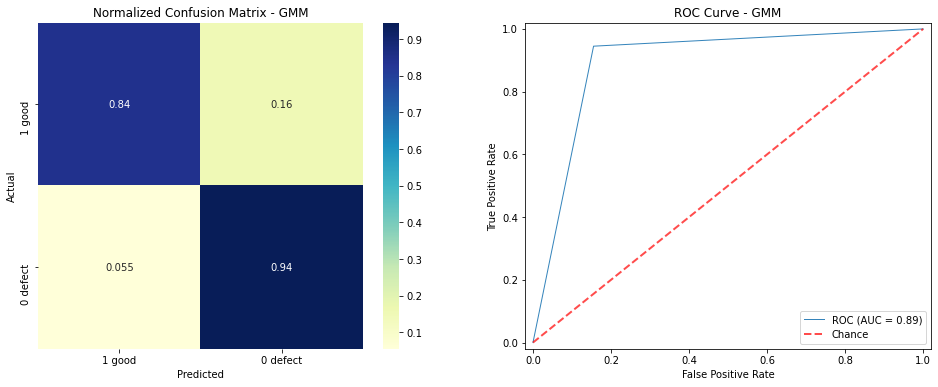

In [308]:
gmm_auc = clust_eval(labels, Y_train, "GMM")
aucs.append(gmm_auc)

# K-Means

In [181]:
#K means


kmeans = KMeans(n_clusters=2).fit(X_train[Y_train==1])
km_label = kmeans.labels_
km_center = kmeans.cluster_centers_

km_pred = kmeans.predict(X_train)


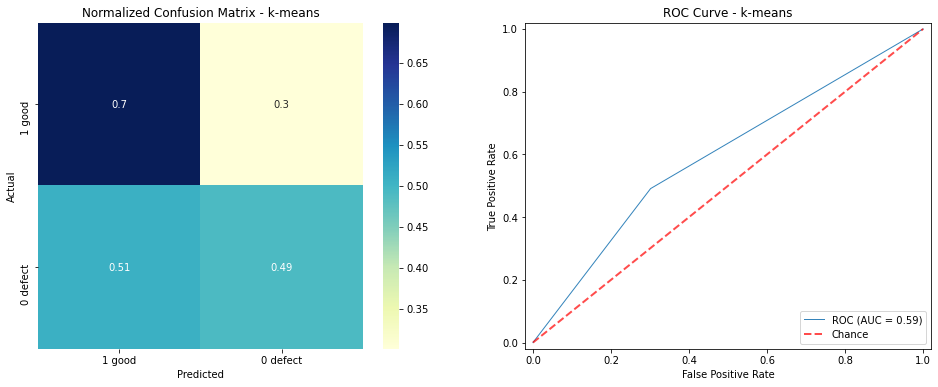

In [309]:
km_auc = clust_eval(km_pred , Y_train, "k-means")
aucs.append(km_auc)

# One Class SVM

In [310]:
clf = OneClassSVM(kernel='sigmoid',
                  degree=3,
                  gamma='auto',
                  coef0=1,
                  tol=0.00001,
                  nu=0.01,
                  shrinking=False,
                  cache_size=100,
                  verbose=False,
                  max_iter=10000).fit(X_train[Y_train==1])

ocsvm_pred = clf.predict(X_train)


ocsvm_pred[ocsvm_pred==-1]=0


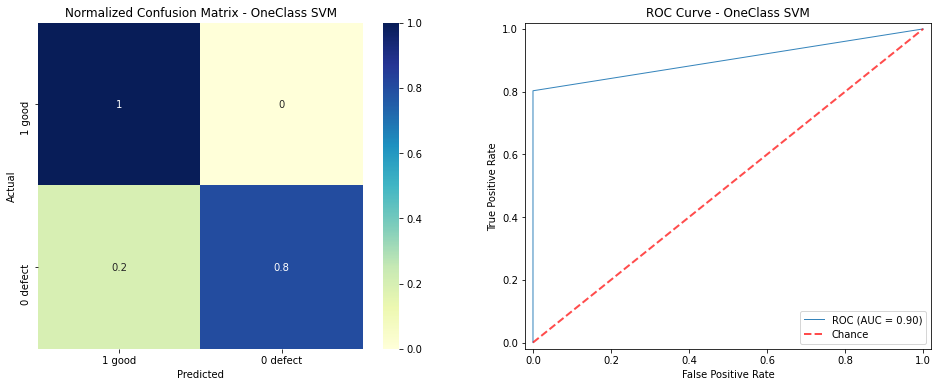

In [314]:
svmauc = clust_eval(ocsvm_pred, Y_train, "OneClass SVM")
aucs.append(svmauc)

# Autoencoder

In [58]:
#input_dim = X_train[0].shape[1]

loss_fn = "mse"#KLDivergence()# mean_squared_error# "mse"# MeanSquaredError()# BinaryCrossentropy() loss='kld'

file = Path(f'modelle//autoencoder_{time.time()}.h5').absolute().as_posix()

input_dim = x_train[y_train==1].shape[1]


In [59]:
nb_epoch = 1000
batch_size = 5
patience = 40
    

In [60]:

autoencoder, checkpointer, early_stopping = create_model(loss_fn, input_dim, file)

autoencoder.summary()

Model: "model_103"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_104 (InputLayer)       [(None, 222)]             0         
_________________________________________________________________
dense_412 (Dense)            (None, 111)               24753     
_________________________________________________________________
dropout_206 (Dropout)        (None, 111)               0         
_________________________________________________________________
dense_413 (Dense)            (None, 55)                6160      
_________________________________________________________________
dropout_207 (Dropout)        (None, 55)                0         
_________________________________________________________________
dense_414 (Dense)            (None, 111)               6216      
_________________________________________________________________
dense_415 (Dense)            (None, 222)               24

In [61]:
print(f'saving model to {file}')
history = autoencoder.fit(x_train[y_train==1], x_train[y_train==1],
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,                                                                 
                    validation_data=(x_valid[y_valid==1], x_valid[y_valid==1]),
                    verbose=0,
                    callbacks=[checkpointer, early_stopping])

#autoencoder.save_weights('./results/ae_weights.h5')

saving model to D:/Documents/Uni/!code/git/python/proj/modelle/autoencoder_1596621733.3330572.h5


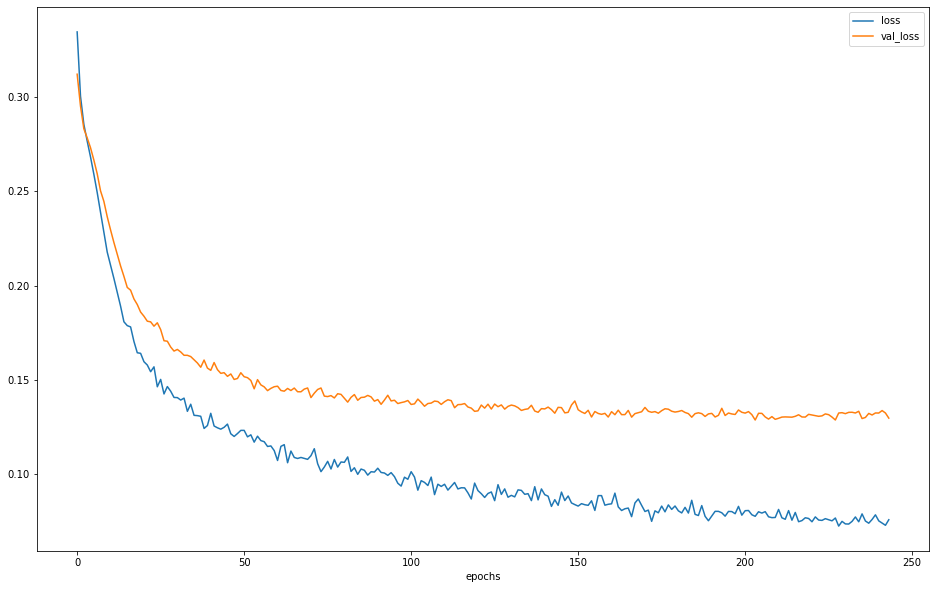

min val loss: 0.1286543309688568


In [23]:
#ticks = np.arange(0.0,1.01,0.05)

fig = plt.figure(figsize=(16,10))
df = pd.DataFrame(history.history)

#plt.yticks(ticks)
#plt.ylim(0.1,1.05)
plt.xlabel('epochs')
plt.plot(df)
plt.legend(df.columns)
plt.show()

print('min val loss:',min(history.history['val_loss']))

## classify with autoencoder reconstruction error

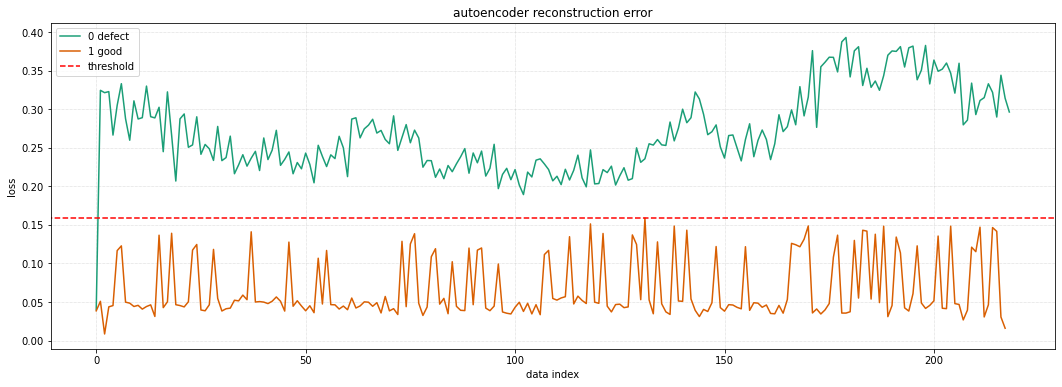

Mean mse of decoded vals: 0.16846844635199412
Decision threshold of decoded vals: 0.1588484977578332
Class prediction done:  [0 1] [219 218]


In [24]:
#autoencoder = load_model("autoencoder3.h5")

fig = plt.figure(figsize=(18,6))
plt.ylabel('loss')
plt.xlabel('data index')
#plt.ylim((0, 1000))
plt.title('autoencoder reconstruction error')

plt.grid(linestyle=':', linewidth=0.5)

for i in [0, 1]:
    predictions = autoencoder.predict(X_train[Y_train==i])
    
    color = cm.Dark2(i)
    
    #loss = loss_fn(X_train[Y_train==i], predictions).numpy()
    loss = np.mean(np.power(X_train[Y_train==i] - predictions, 2), axis=1)

    error_df = pd.DataFrame({'reconstruction_error': loss, 'true_class': Y_train[Y_train==i]})
    error_df.sort_index(inplace=True)
    error_df.reset_index(inplace=True)
    plt.plot(error_df['reconstruction_error'], label=f'{i} {title[i]}', color=color)
    

predictions = autoencoder.predict(X_train)
mse = np.mean(np.power(X_train - predictions, 2), axis=1)
threshold = np.max(error_df[1:]['reconstruction_error'])


plt.axhline(threshold,-5,235, color='r', linestyle='--', label='threshold')
plt.legend()
plt.show()

print(f'Mean mse of decoded vals: {np.mean(mse)}\nDecision threshold of decoded vals: {threshold}')


y_pred_ae = ae_classy(mse,threshold)
        
        
unique, counts = np.unique(y_pred_ae, return_counts=True)
    
print('Class prediction done: ',unique,counts)


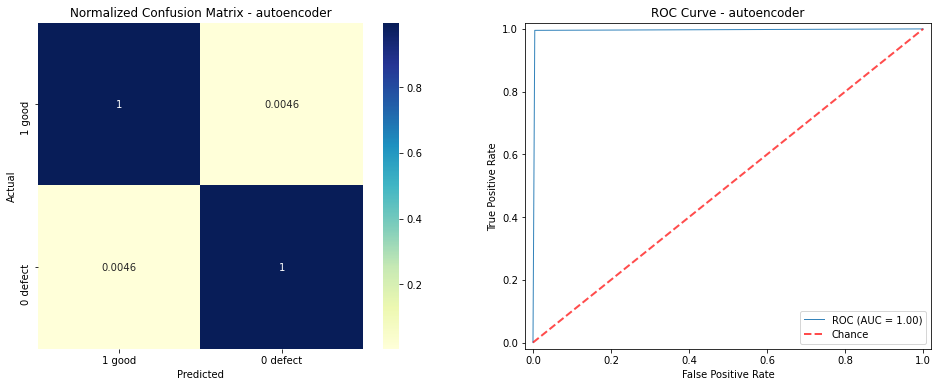

In [316]:
y_pred_ae = np.array(y_pred_ae)

ae_auc = clust_eval(y_pred_ae, Y_train, "autoencoder")
aucs.append(ae_auc)

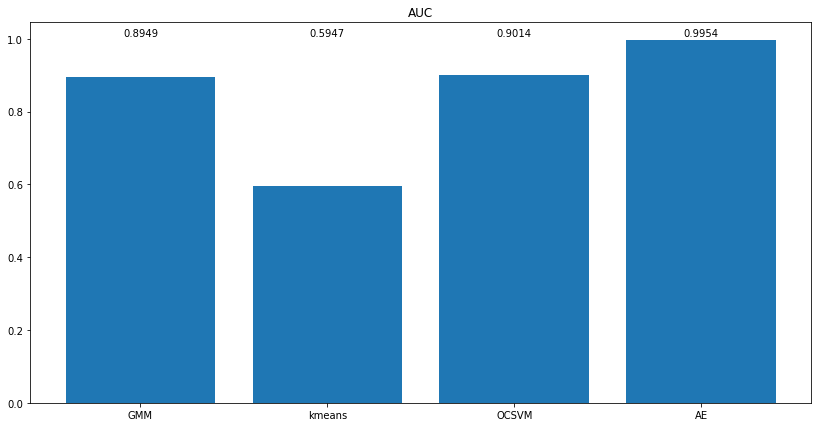

In [355]:
tit = ['GMM', 'kmeans', 'OCSVM', 'AE']
pos = range(len(tit))

fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(111)

ax.bar(pos, aucs, align='center')
plt.xticks(pos, tit)
ax.set_title('AUC')




for ind, i in enumerate(ax.patches):
    ax.annotate(f'{aucs[ind]:.4}', (ind,1), xytext=(0,1), textcoords="offset points",
                    ha='center', va='bottom')
    
plt.show()

# Visualisierung des Datensets mit t-SNE

In [26]:

X_train_tsne = []
lr = 10

p = [3] #[1, 3, 5, 10, 30, 50, 90] 


for ind, i in enumerate(p):
    print(f'##############\n{ind+1}/{len(p)}: t-sne p={i} learning_rate={lr} for {np.shape(X_train)}\n##############')
    tsne = TSNE(n_components=2,  perplexity=i, learning_rate=lr, verbose=0, angle=0.2, n_jobs=-1)
    Y = tsne.fit_transform(X_train)

    X_train_tsne.append(Y)

##############
1/1: t-sne p=3 learning_rate=10 for (437, 222)
##############


############## plot (437, 2)  for p = 3 ####################################################################


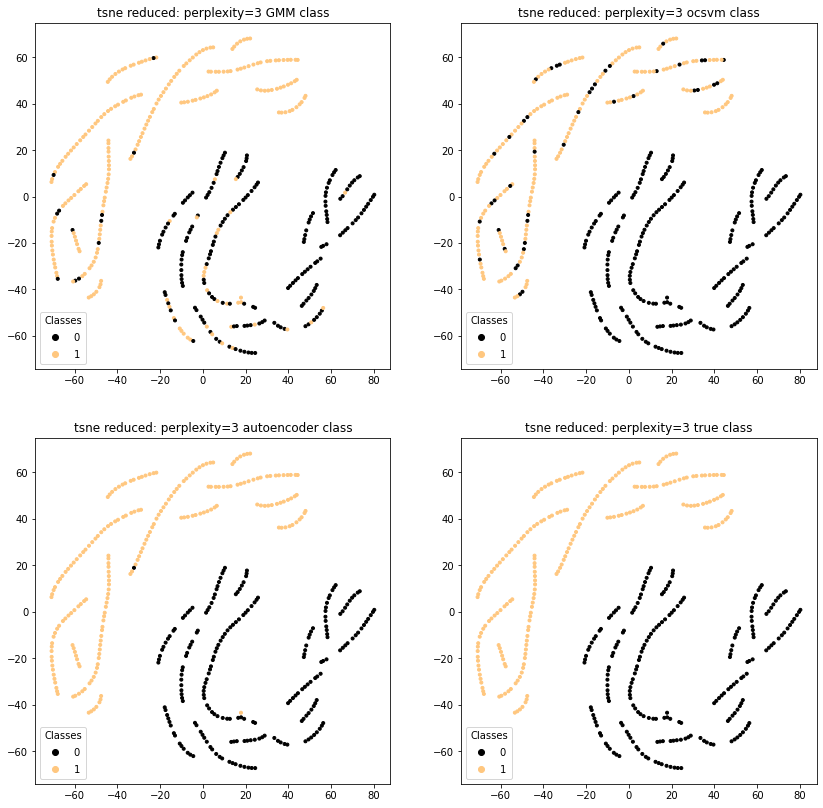

In [301]:
for i, Y in zip(p, X_train_tsne):
    print('############## plot',np.shape(Y),' for p =',i,'####################################################################')
    fig = plt.figure(figsize=(14,14))
    ax = fig.add_subplot(221)
    ax.set_title(f'tsne reduced: perplexity={i} GMM class')
    scat = ax.scatter(Y[:,0], Y[:,1], marker='.', c=labels , cmap=cm. copper)
    plt.legend(*scat.legend_elements(), loc="lower left", title="Classes")
    
    ax1 = fig.add_subplot(222)
    ax1.set_title(f'tsne reduced: perplexity={i} ocsvm class')
    scat1 = ax1.scatter(Y[:,0], Y[:,1], marker='.', c=ocsvm_pred , cmap=cm.copper)
    plt.legend(*scat1.legend_elements(), loc="lower left", title="Classes")

    ax2 = fig.add_subplot(223)
    ax2.set_title(f'tsne reduced: perplexity={i} autoencoder class')
    scat2 = ax2.scatter(Y[:,0], Y[:,1], marker='.', c=y_pred_ae, cmap=cm.copper)
    plt.legend(*scat2.legend_elements(), loc="lower left", title="Classes")
    
    ax3 = fig.add_subplot(224)
    ax3.set_title(f'tsne reduced: perplexity={i} true class')
    scat3 = ax3.scatter(Y[:,0], Y[:,1], marker='.', c=Y_train, cmap=cm.copper)
    plt.legend(*scat3.legend_elements(), loc="lower left", title="Classes")
    
    plt.show()
    

# Lernkurve Autoencoder

In [35]:
loss_0 = []
loss_1 = []
loss_train = []
loss_val = []

time_start2 = time.time()
time_start = time.time()
over = [1 ,2 , 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97,
        102, 107, 112, 122, 142, 152, 162, 172, 182, 192, 202, 212, 222]

interval = len(over)/4

print(f'learning curve for {len(over)} iterations... ')

for ind, d in enumerate(over):
    
    file = Path(f'lc//autoencoder_{time.time()}_{ind}.h5').absolute().as_posix()

    x_train_lc = x_train[y_train==1][:d]
    x_valid_lc = x_valid[y_valid==1][:d]
    X_train[Y_train==i]
    
    lcmodel, checkpointer, early_stopping = create_model(loss_fn, input_dim, file)

    
    lchistory = lcmodel.fit(x_train_lc, x_train_lc,
                            epochs=nb_epoch,
                            batch_size=batch_size,
                            shuffle=True,  
                            validation_data=(x_valid_lc, x_valid_lc),
                            verbose=0,
                            callbacks=[checkpointer, early_stopping])
    
    loss = []
    
    for i in [0,1]:
        predictions = lcmodel.predict(X_train[Y_train==i])
        loss.append(np.mean(np.power(X_train[Y_train==i] - predictions, 2), axis=1))
    
    loss_train.append(np.mean(lchistory.history['loss']))
    loss_val.append(np.mean(lchistory.history['val_loss']))
    loss_0.append(np.mean(loss[0]))
    loss_1.append(np.mean(loss[1]))
    
    if (interval==ind+1):
        print(f'Done {ind+1} iterations so far.. took {time.time()-time_start:.8}s..')
        time_start = time.time()
        interval=interval+len(over)/4
        
print(f'Done... took {time.time()-time_start2:.8}s')

learning curve for 44 iterations... 
Done 11 iterations so far.. working for 149.96357s so far..
Done 22 iterations so far.. working for 242.72547s so far..
Done... took 1387.2441s


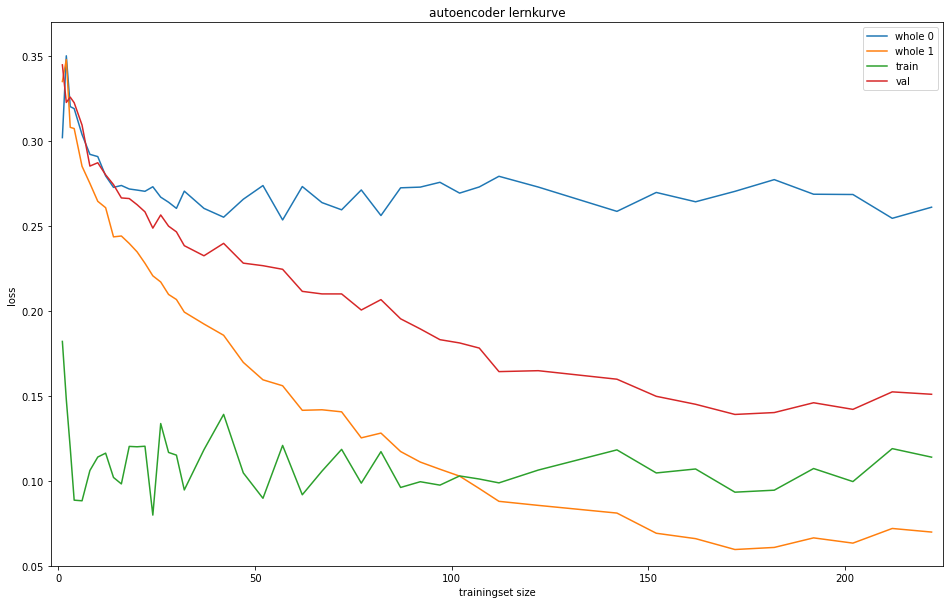

In [72]:
fig = plt.figure(figsize=(16,10))

plt.ylim(0.05,0.37)
plt.xlim(-2,225)
plt.title('autoencoder lernkurve')
plt.xlabel('trainingset size')
plt.ylabel('loss')
plt.plot(over, loss_0, label='whole 0')
plt.plot(over, loss_1, label='whole 1')
plt.plot(over, loss_train, label='train')
plt.plot(over, loss_val, label='val')
plt.legend()
plt.show()


# Fazit